## Multi time series prediction using FBProphet

Generally speaking, fbProphet works best with time series data that have strong seasonal effect and several seasons within the provided historical data.

it implement an additive regression model. Pricewise linear (i.e. it picks up change point in the data trend and identify trend change)

Building and testing the Facebook prophet before using it in final projection:
- General cleaning and data preparation
- Prediction per MEV
- Final app structure and where does FB Prophet fit 

**Data preparation**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
from time import time

In [2]:
mev = pd.read_excel('allCountries_IMF.xlsx')

In [3]:
mev.columns.values

array(['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
       'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
       'Country/Series-specific Notes', 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021], dtype=object)

In [4]:
mev = mev.drop(columns=['WEO Country Code', 'ISO', 'WEO Subject Code', 'Subject Notes', 'Scale',
       'Country/Series-specific Notes',])


mev.head(2)

,Country,Subject Descriptor,Units,1980,1981,1982,1983,1984,1985,1986,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,"Gross domestic product, constant prices",National currency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1092.12,1154.18,1185.31,1197.01,1222.92,1255.29,1270.22,1319.9,1253.91,1304.06
1,Afghanistan,"Gross domestic product, constant prices",Percent change,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.968,5.683,2.697,0.988,2.164,2.647,1.189,3.912,-5,4


In [5]:
df = pd.melt(mev, id_vars=['Country', 'Subject Descriptor', 'Units'], var_name='year', value_name='mev_value')

In [6]:
df_comp = df.dropna(subset=['mev_value'])

In [7]:
df_comp.isnull().sum()

Country               0
Subject Descriptor    0
Units                 0
year                  0
mev_value             0
dtype: int64

In [8]:
def change_names(df):
  if df['Subject Descriptor'] == 'Gross domestic product, current prices' and df['Units'] == 'U.S. dollars':
    return 'GDP'
  elif df['Subject Descriptor'] == 'Inflation, end of period consumer prices' and df['Units'] == 'Index':
    return 'Inflation, CPI'
  elif df['Subject Descriptor'] == 'Unemployment rate':
    return 'Unemployment rate'
  else:
    return 'Other'



df_comp['mev_name'] = df_comp.apply(change_names, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [9]:
df_smaller = df_comp[df_comp['mev_name'] != 'Other']
df_smaller.head(2)

,Country,Subject Descriptor,Units,year,mev_value,mev_name
48,Albania,"Gross domestic product, current prices",U.S. dollars,1980,1.946,GDP
70,Albania,Unemployment rate,Percent of total labor force,1980,5.028,Unemployment rate


In [10]:
df_smaller['year'] = pd.to_datetime(df_smaller['year'], format='%Y')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
df_smaller_s = df_smaller[['Country','year','mev_value','mev_name']]

In [12]:
gdp_df = df_smaller_s[df_smaller_s['mev_name']=='GDP']
unemp_df = df_smaller_s[df_smaller_s['mev_name']=='Unemployment rate']
cpi_df = df_smaller_s[df_smaller_s['mev_name']=='Inflation, CPI']

In [13]:
cpi_df['mev_value'].replace('--',0,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [14]:
gdp_df.head(2)

,Country,year,mev_value,mev_name
48,Albania,1980-01-01,1.946,GDP
93,Algeria,1980-01-01,42.346,GDP


In [15]:
unemp_df.head(2)

,Country,year,mev_value,mev_name
70,Albania,1980-01-01,5.028,Unemployment rate
115,Algeria,1980-01-01,15.789,Unemployment rate


In [16]:
cpi_df.head(2)

,Country,year,mev_value,mev_name
108,Algeria,1980-01-01,6.573,"Inflation, CPI"
153,Angola,1980-01-01,0.000,"Inflation, CPI"


In [17]:
gdp_df.drop(columns='mev_name', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
gdp_df_piv = pd.pivot_table(data=gdp_df, index='year', columns='Country', values='mev_value', aggfunc='sum',fill_value=0).rename_axis(None,axis=1).reset_index()
gdp_df_piv

,year,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,1980-01-01,0.000,1.946,42.346,6.639,0.131,233.696,0.000,0.000,162.628,...,2857.33,12.165,0.000,0.121,69.841,35.357,0.000,0.000,4.246,0.000
1,1981-01-01,0.000,2.229,44.372,6.214,0.148,189.802,0.000,0.000,188.067,...,3207.03,13.578,0.000,0.114,78.367,17.617,0.000,0.000,4.385,0.000
2,1982-01-01,0.000,2.296,44.780,6.214,0.164,94.250,0.000,0.000,186.709,...,3343.80,11.100,0.000,0.114,79.998,23.369,0.000,0.000,4.232,0.000
3,1983-01-01,0.000,2.319,47.529,6.476,0.182,116.267,0.000,0.000,179.151,...,3634.03,6.093,0.000,0.117,79.672,35.204,0.000,0.000,3.653,0.000
4,1984-01-01,0.000,2.290,51.513,6.864,0.208,130.544,0.000,0.000,196.777,...,4037.65,5.794,0.000,0.144,57.826,61.171,0.000,0.000,3.003,0.000
5,1985-01-01,0.000,2.339,61.132,8.457,0.241,98.599,0.000,0.000,174.067,...,4339.00,5.662,0.000,0.132,59.865,19.045,0.000,0.000,2.848,0.000
6,1986-01-01,0.000,2.587,61.535,7.918,0.290,118.565,0.000,0.000,181.147,...,4579.63,7.029,0.000,0.128,60.877,43.009,0.000,0.000,1.962,0.000
7,1987-01-01,0.000,2.566,63.300,9.050,0.337,121.561,0.000,0.000,212.712,...,4855.25,8.794,0.000,0.139,46.854,53.385,0.000,0.000,2.431,0.000
8,1988-01-01,0.000,2.530,51.664,9.818,0.399,142.386,0.000,0.000,270.594,...,5236.43,9.098,0.000,0.158,60.378,29.501,0.000,0.000,4.095,0.000
9,1989-01-01,0.000,2.779,52.558,11.421,0.439,91.352,0.000,0.000,307.720,...,5641.60,9.589,0.000,0.154,44.672,7.991,0.000,0.000,4.365,0.000


---
**Prediction**

In [19]:
fb_gdp = gdp_df_piv[['year','United States']]
fb_gdp.columns = ['ds','y']
fb_gdp

,ds,y
0,1980-01-01,2857.33
1,1981-01-01,3207.03
2,1982-01-01,3343.80
3,1983-01-01,3634.03
4,1984-01-01,4037.65
5,1985-01-01,4339.00
6,1986-01-01,4579.63
7,1987-01-01,4855.25
8,1988-01-01,5236.43
9,1989-01-01,5641.60


In [20]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(fb_gdp)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = m.make_future_dataframe(periods=10,freq='A')
forecast = m.predict(future)
#[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1980-01-01,61.056600,2671.422566,3036.131570,61.056600,61.056600,45.877726,45.877726,45.877726,45.877726,45.877726,45.877726,0.0,0.0,0.0,2862.194544
1,1981-01-01,66.466787,2991.326473,3340.368209,66.466787,66.466787,46.573414,46.573414,46.573414,46.573414,46.573414,46.573414,0.0,0.0,0.0,3162.051984
2,1982-01-01,71.860864,3223.794758,3596.445048,71.860864,71.860864,46.380084,46.380084,46.380084,46.380084,46.380084,46.380084,0.0,0.0,0.0,3404.773751
3,1983-01-01,77.254942,3465.861315,3830.084775,77.254942,77.254942,46.148093,46.148093,46.148093,46.148093,46.148093,46.148093,0.0,0.0,0.0,3642.423201
4,1984-01-01,85.275555,3824.601950,4178.098568,85.275555,85.275555,45.877726,45.877726,45.877726,45.877726,45.877726,45.877726,0.0,0.0,0.0,3997.524071


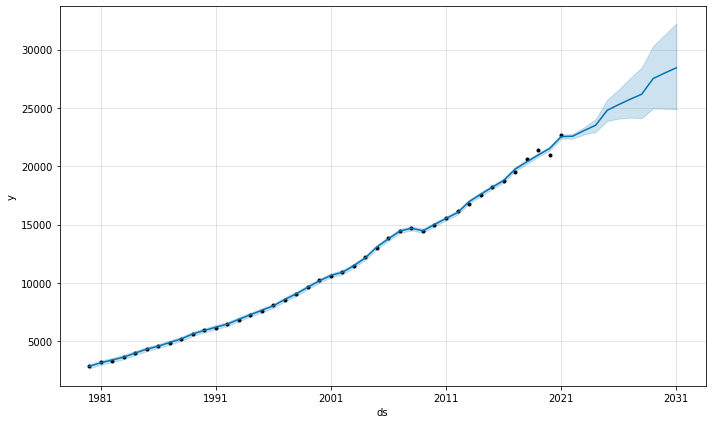

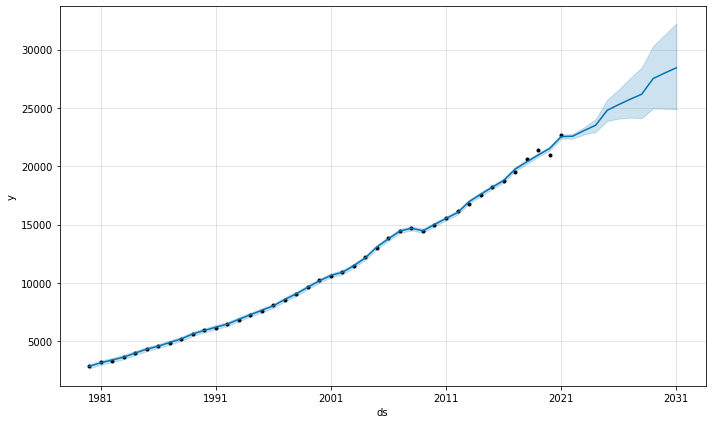

In [22]:
m.plot(forecast)

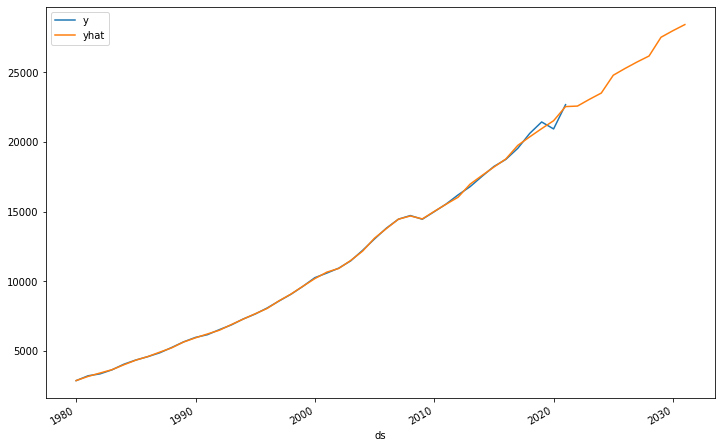

In [23]:
pd.concat([fb_gdp.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot(figsize=(12,8))

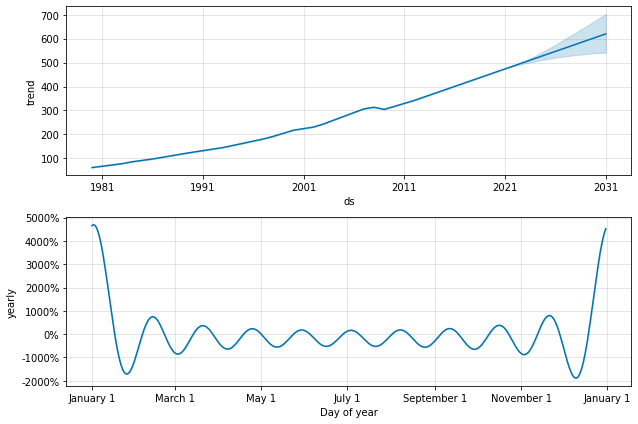

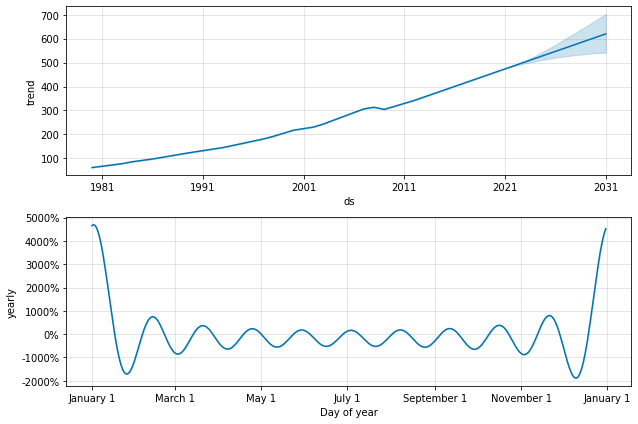

In [24]:
m.plot_components(forecast)

In [ ]:
smaller_gdp_df = gdp_df_piv[['year','Australia','Brazil','Switzerland','Canada','United States','United Kingdom']]
smaller_gdp_df.head()

,year,Australia,Brazil,Switzerland,Canada,United States,United Kingdom
0,1980-01-01,162.628,145.819,122.701,276.035,2857.33,603.983
1,1981-01-01,188.067,167.583,112.293,307.246,3207.03,587.652
2,1982-01-01,186.709,179.166,114.856,314.639,3343.80,558.720
3,1983-01-01,179.151,143.652,114.512,341.863,3634.03,532.476
4,1984-01-01,196.777,142.957,109.596,356.728,4037.65,504.571


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forcasting for Australia over 10 years horizon:



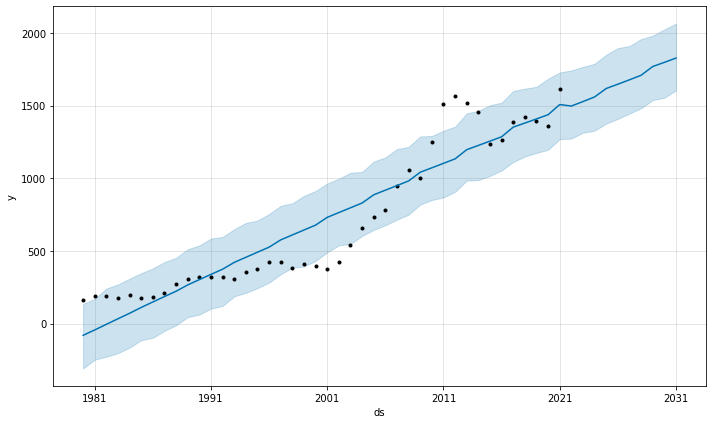

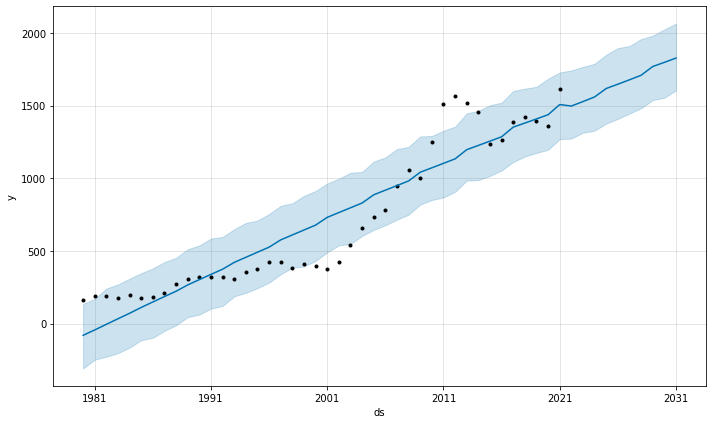

In [ ]:
print(f'forcasting for Australia over 10 years horizon:\n')
df = gdp_df_piv[['year','Australia']]
df.columns = ['ds','y']
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=10,freq='A')
forecast = m.predict(future)
m.plot(forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forcasting for Brazil over 10 years horizon:



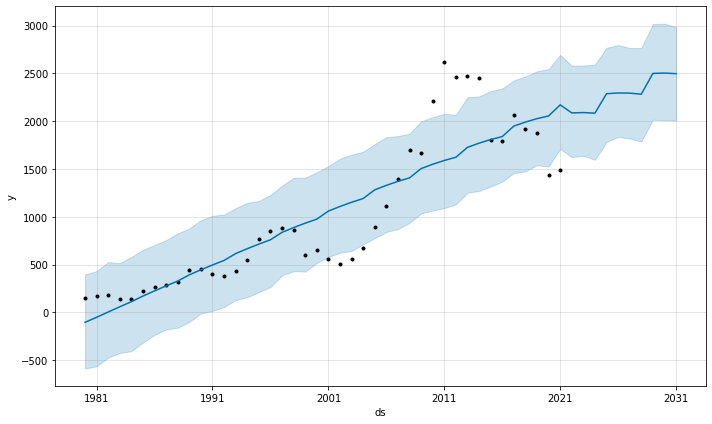

In [ ]:

print(f'forcasting for Brazil over 10 years horizon:\n')
df = gdp_df_piv[['year','Brazil']]
df.columns = ['ds','y']
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=10,freq='A')
forecast = m.predict(future)
m.plot(forecast)
print('='*100)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forcasting for Switzerland over 10 years horizon:



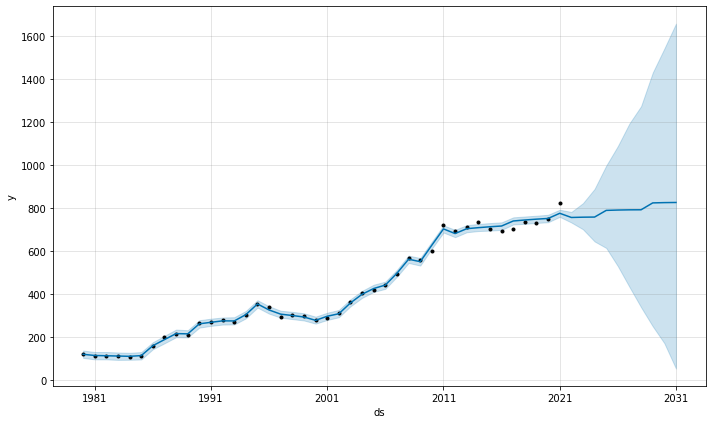

In [ ]:

print(f'forcasting for Switzerland over 10 years horizon:\n')
df = gdp_df_piv[['year','Switzerland']]
df.columns = ['ds','y']
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=10,freq='A')
forecast = m.predict(future)
m.plot(forecast)
print('='*100)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forcasting for Canada over 10 years horizon:



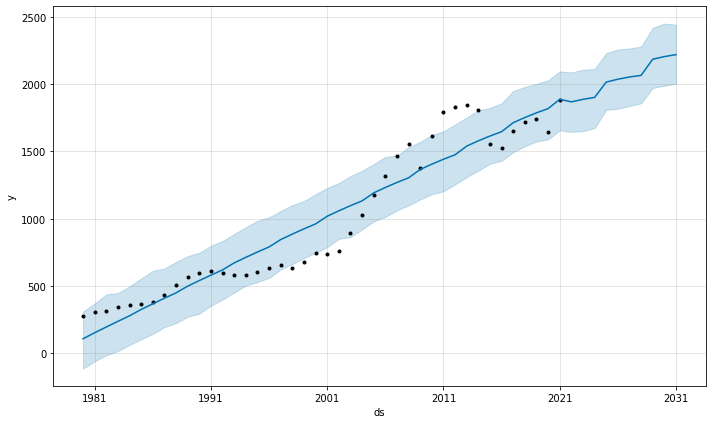

In [ ]:

print(f'forcasting for Canada over 10 years horizon:\n')
df = gdp_df_piv[['year','Canada']]
df.columns = ['ds','y']
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=10,freq='A')
forecast = m.predict(future)
m.plot(forecast)
print('='*100)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forcasting for United States over 10 years horizon:



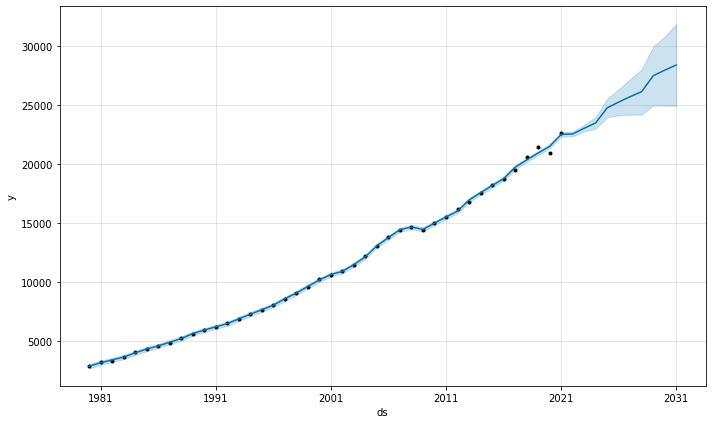

In [ ]:
print(f'forcasting for United States over 10 years horizon:\n')
df = gdp_df_piv[['year','United States']]
df.columns = ['ds','y']
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=10,freq='A')
forecast = m.predict(future)
m.plot(forecast)
print('='*100)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forcasting for United Kingdom over 10 years horizon:



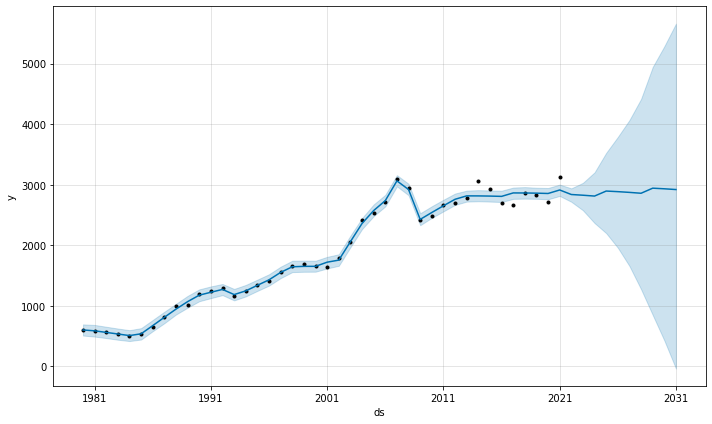

In [ ]:
print(f'forcasting for United Kingdom over 10 years horizon:\n')
df = gdp_df_piv[['year','United Kingdom']]
df.columns = ['ds','y']
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=10,freq='A')
forecast = m.predict(future)
m.plot(forecast)
print('='*100)

# Building App structure
------------------
------------------

1. Choose **target MEV** to predict/calculate: For instance GDP
2. Choose **target country**
3. Horizon of the prediction needed (How many n years/quarters in the future to predict)
4. Present a correlation/clusters The target country belong too, along with list of countries in the cluster
5. Filter out countries with **low predictive power** toward our target country
6. Retreive countrie' MEV projection available with user (for instance UK projection under stress scenario)
7. **Run first VAR to calculate C1 projection step 1**
8. Use FBProphet to predict n years, return smaller df with country's $\hat{y}$ n period in future
9. Merge it with:
  * users projection step 1 (to have first row of x_test)
  * target country's MEV predicted in (7)
10. Now we have the full row of step 1 (Target projection, user input projection and fbProphet first row). **Repeat 7,8 and 9 step wise until we have all projections**

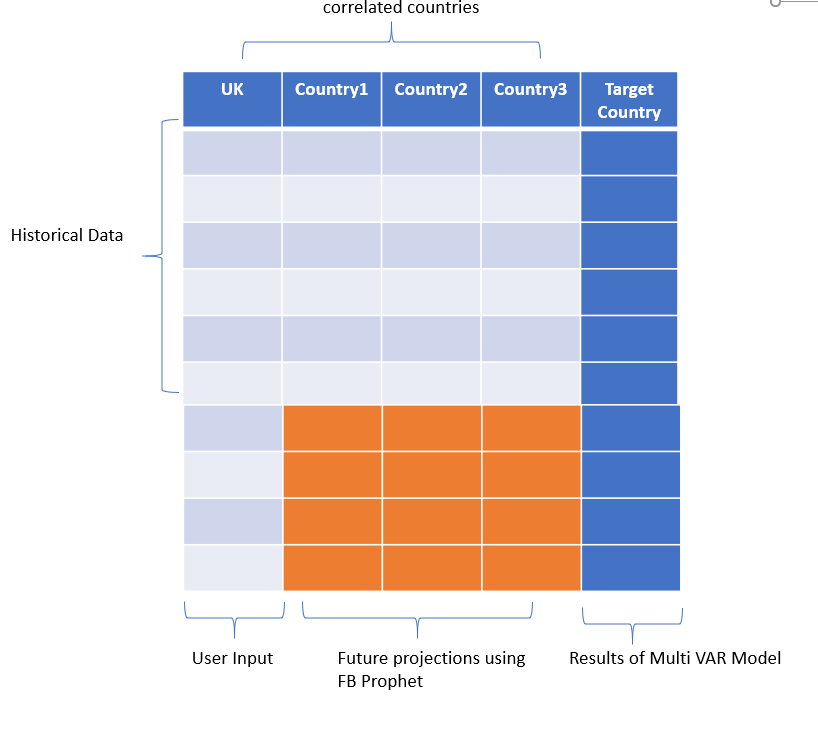

In [74]:
gdp_df_imf = pd.read_excel('/content/gdp_imf_clustered.xlsx')

In [75]:
print('List of countries:\n',gdp_df_imf['country'].values.tolist())
target_country = input('\n\nWhich country you want to project or calculate the "GDP" to? write as in list above').title()

List of countries:
 ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq', 'Ireland', 

In [76]:
target_country

'Italy'

In [77]:
# get the cluster
target_cluster = gdp_df_imf[gdp_df_imf['country']==target_country]['Cluster'].values[0]
# get the target df
target_df = gdp_df_imf[gdp_df_imf['Cluster']==target_cluster]
# list of countries in the cluster
target_cluster_countries = target_df['country'].tolist()

In [79]:
# get list of countries to predict to 
# make it in an if else statement

print(f'{target_country} shares cluster {target_cluster} with:\n{target_cluster_countries}\n\n')

Italy shares cluster 3 with:
['Australia', 'Brazil', 'Canada', 'France', 'India', 'Indonesia', 'Italy', 'Korea', 'Mexico', 'Netherlands', 'Russia', 'Spain', 'Turkey', 'United Kingdom']




In [99]:
user_choice = input('Do you want to provide projections for one of the countries? answer with yes or no\n ').lower()

countries_to_drop = []
countries_to_drop.append(target_country)

countries_to_predict = []

if user_choice == 'no':
  print('No Country Provided, we will predict them all💪\n')
  #countries_to_predict = [c for c in target_cluster_countries if c != countries_to_drop]
else:
  user_input_proj = input('What country you have projection to? write the name as in list above!\n ').title()
  if user_input_proj not in target_cluster_countries:
    print(f'country you provide {user_input_proj} is not in the list of countries in cluster {target_cluster}\nOr its not written correctly')
  else:
    countries_to_drop.append(user_input_proj)
    #countries_to_predict = [c for c in target_cluster_countries if c not in countries_to_drop]



countries_to_predict = [c for c in target_cluster_countries if c not in countries_to_drop]

Do you want to provide projections for one of the countries? answer with yes or no
 no
No Country Provided, we will predict them all💪



In [100]:
countries_to_predict, len(countries_to_predict)

(['Australia',
  'Brazil',
  'Canada',
  'France',
  'India',
  'Indonesia',
  'Korea',
  'Mexico',
  'Netherlands',
  'Russia',
  'Spain',
  'Turkey',
  'United Kingdom'],
 13)

In [123]:
# preprocessing the dataframe before running the prediction

processed_df = target_df.drop(columns='Cluster').T.reset_index()
processed_df.columns = processed_df.loc[0]
processed_df = processed_df.iloc[1:,:]
processed_df.rename(columns={"country": "year" }, inplace = True)
processed_df['year'] = pd.to_datetime(processed_df['year'], format='%Y')
processed_df.head()

,year,Australia,Brazil,Canada,France,India,Indonesia,Italy,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom
1,1980-01-01,162.628,145.819,276.035,702.243,189.438,99.296,482.019,65.368,228.606,193.758,0.0,230.759,96.596,603.983
2,1981-01-01,188.067,167.583,307.246,618.954,196.535,110.848,437.124,72.934,293.61,162.4,0.0,204.588,97.865,587.652
3,1982-01-01,186.709,179.166,314.639,588.015,203.537,113.799,432.001,78.349,213.077,157.338,0.0,197.643,88.918,558.72
4,1983-01-01,179.151,143.652,341.863,562.499,222.049,103.149,448.304,87.761,173.714,153.179,0.0,172.856,84.968,532.476
5,1984-01-01,196.777,142.957,356.728,532.339,215.556,107.218,442.925,97.511,204.86,142.578,0.0,172.381,82.642,504.571


In [147]:
prediction_horizon = 3

In [124]:
# predicting fbProphet 

prediction_df = pd.DataFrame()

for i in processed_df[countries_to_predict].columns:
  df = processed_df[['year',i]]
  df.columns = ['ds','y']
  m = Prophet(seasonality_mode='multiplicative')
  m.fit(df)
  future = m.make_future_dataframe(periods=prediction_horizon,freq='A')
  forecast = m.predict(future)[['ds', 'yhat']]
  #print(forecast)
  prediction_df[i] = forecast.iloc[:, 1]
  prediction_df['ds'] = forecast.iloc[:, 0]
  

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [125]:
prediction_df

,Australia,ds,Brazil,Canada,France,India,Indonesia,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom
0,-80.622650,1980-01-01,-103.968346,108.632588,680.070616,183.588135,-126.089329,63.668256,60.774244,90.666073,-383.716647,103.124157,-46.523957,600.290918
1,-43.541930,1981-01-01,-51.368790,153.501016,636.229985,200.538722,-99.890586,74.030758,93.674022,112.759613,-341.033961,139.151382,-22.975676,586.158114
2,-4.796801,1982-01-01,4.109683,196.145381,597.054608,207.741072,-72.467502,80.618539,124.922787,135.411040,-281.150490,175.964840,0.071548,559.937552
3,33.375394,1983-01-01,58.685429,238.109369,557.842234,214.549589,-45.330791,86.937813,155.083942,157.858237,-222.381595,212.448524,23.277817,533.549340
4,71.054274,1984-01-01,111.857474,279.160713,532.438643,220.948355,-18.363471,92.973755,183.547484,179.958658,-164.845662,248.298842,46.604135,507.427606
5,111.395778,1985-01-01,170.804907,326.450253,601.190394,241.290888,8.691863,104.757412,219.322340,201.834610,-114.078981,283.971206,69.275301,536.858544
6,148.948132,1986-01-01,224.836778,368.599313,756.636211,259.330656,35.673160,115.025113,250.428628,224.748563,-56.736623,321.307741,92.666807,672.412396
7,186.032959,1987-01-01,277.295698,409.755933,880.267525,276.652207,62.524237,155.624911,279.631025,247.268319,-0.663490,357.909760,116.165563,809.566935
8,222.731198,1988-01-01,327.683294,449.688839,1001.720605,293.215050,89.362387,194.863355,306.320725,269.251243,54.025324,393.473528,139.732226,944.554777
9,266.333486,1989-01-01,392.978603,499.399490,1117.502941,306.683935,117.274313,246.971251,344.970658,290.909606,112.876000,428.791030,161.526279,1068.517369


In [145]:
original_period = len(prediction_df) - prediction_horizon
first_step = prediction_horizon -1

prediction_df[original_period:-first_step]

,Australia,ds,Brazil,Canada,France,India,Indonesia,Korea,Mexico,Netherlands,Russia,Spain,Turkey,United Kingdom
42,1497.129519,2022-01-10,2086.438634,1868.470496,2655.008195,3016.764055,1007.428074,1726.288691,1284.088219,1018.944772,1861.02847,1607.256896,934.743546,2838.286131


In [151]:
# taking users input and add it to df

all_numbers = []
for i in range(prediction_horizon):
  inp = int(input(f'Add the GDP numbers {i} :'))
  all_numbers.append(inp)


Add the GDP numbers 0 :6
Add the GDP numbers 1 :8
Add the GDP numbers 2 :9


In [154]:
all_numbers2 = pd.Series(all_numbers)

prediction_df['Australia'].append(all_numbers2)

0      -80.622650
1      -43.541930
2       -4.796801
3       33.375394
4       71.054274
5      111.395778
6      148.948132
7      186.032959
8      222.731198
9      266.333486
10     302.693064
11     338.690524
12     374.408122
13     421.271194
14     456.438044
15     491.349420
16     526.098943
17     576.235977
18     610.233399
19     644.094836
20     677.893579
21     731.329838
22     764.157963
23     796.950590
24     829.785106
25     886.505182
26     918.156928
27     949.867533
28     981.724668
29    1041.711173
30    1072.168079
31    1102.789434
32    1133.664229
33    1196.917165
34    1226.179230
35    1255.711334
36    1285.603791
37    1352.123156
38    1380.190381
39    1408.633235
40    1437.543352
41    1507.329148
42    1497.129519
43    1527.985727
44    1559.669035
45    1618.077209
46    1647.429515
47    1677.630232
48    1708.768426
49    1769.142483
50    1797.729511
51    1827.274737
0        6.000000
1        8.000000
2        9.000000
dtype: flo

# End